# Activation patching basic


In [3]:

%load_ext autoreload
%autoreload 2
# # # set cuda visible device
# !export CUDA_VISIBLE_DEVICES=3
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

starcoderbase_1b = "/home/arjun/models/starcoderbase-1b/"

from nnsight import LanguageModel
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
import datasets
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
import plotly.express as px

from nnsight import LanguageModel, util
from nnsight.tracing.Proxy import Proxy

import datasets
import sys
sys.path.append("../")
from patching_exp.wrong_type_patching import *
from patching_exp.type_patching import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model = LanguageModel(starcoderbase_1b, device_map='cuda:0')
model

GPTBigCodeForCausalLM(
  (transformer): GPTBigCodeModel(
    (wte): Embedding(49152, 2048)
    (wpe): Embedding(8192, 2048)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTBigCodeBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTBigCodeSdpaAttention(
          (c_attn): Linear(in_features=2048, out_features=2304, bias=True)
          (c_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTBigCodeMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(in_features=8192, out_features=2048, bias=True)
          (act): PytorchGELUTanh()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2048,), ep

## Activation patching

In [6]:
ds = datasets.load_dataset("franlucc/starcoderbase-1b-completions_typeinf_analysis", split="train")
string_ex = [d for d in ds if d["generated"] == "string"]
boolean_ex = [d for d in ds if d["generated"] == "boolean"]
number_ex = [d for d in ds if d["generated"] == "number"]

string_idx = model.tokenizer.convert_tokens_to_ids("string")
boolean_idx = model.tokenizer.convert_tokens_to_ids("boolean")
number_idx = model.tokenizer.convert_tokens_to_ids("number")
print(string_idx, boolean_idx, number_idx)



800 4398 2171


In [7]:
# import os
# os.makedirs("str-bool-num-types",exist_ok=True)
# os.makedirs("str-bool-num-types/str",exist_ok=True)
# os.makedirs("str-bool-num-types/bool",exist_ok=True)
# os.makedirs("str-bool-num-types/num",exist_ok=True)
# for i,prog in enumerate(string_ex):
#     with open(f"str-bool-num-types/str/{i}_prog.ts", "w") as f:
#         f.write(str(prog["fim_program"]))
# for i,prog in enumerate(boolean_ex):
#     with open(f"str-bool-num-types/bool/{i}_prog.ts", "w") as f:
#         f.write(str(prog["fim_program"]))
# for i,prog in enumerate(number_ex):
#     with open(f"str-bool-num-types/num/{i}_prog.ts", "w") as f:
#         f.write(str(prog["fim_program"]))
        
    

In [10]:

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pred_results = []
probs_patched_results = []
earliest_layer = []
def get_ds(patch):
    if patch == "string":
        return string_ex
    elif patch == "boolean":
        return boolean_ex
    elif patch == "number":
        return number_ex

patch_src = "string"
patch_dst = "number"
correct_index = model.tokenizer(patch_src)["input_ids"][0]
incorrect_index = model.tokenizer(patch_dst)["input_ids"][0]

import random
# 10 random idx
random.seed(36)
idx_range = [random.randint(0, 500) for i in range(5)]
layers = list(range(13,16))

for i in idx_range:
    with torch.no_grad():
        torch.cuda.empty_cache()
    clean_prompt = get_ds(patch_src)[i]["prompt"]
    corrupted_prompt = get_ds(patch_dst)[i]["prompt"]
    patching_results, patched_predictions = patch_fim_tokens(model, clean_prompt, corrupted_prompt, STARCODER_FIM, correct_index, incorrect_index, layers)
    
    patched_predictions = util.apply(patched_predictions, lambda x: x.value.item(), Proxy)
    patching_results = util.apply(patching_results, lambda x: x.value.item(), Proxy)
    
    probs_patched_results.append(patching_results)
    pred_results.append(patched_predictions)
    
    idx = [j for j, x in enumerate(patched_predictions) if x == correct_index]
    if len(idx) == 0:
        idx = [-1]
    earliest_layer.append(idx[0])

    # clear gpu memory
    with torch.no_grad():
        torch.cuda.empty_cache()

Patching...


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


[800, 2171]


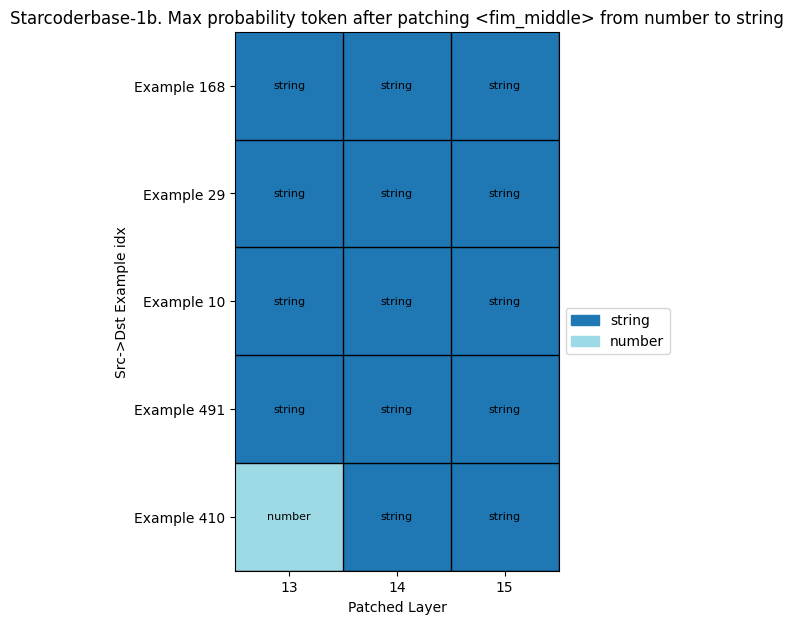

({0: {'pred': 800, 'string': '1.00', 'number': '0.00', 'boolean': '0.00'},
  1: {'pred': 800, 'string': '0.98', 'number': '0.00', 'boolean': '0.00'},
  2: {'pred': 800, 'string': '0.81', 'number': '0.12', 'boolean': '0.00'},
  3: {'pred': 800, 'string': '0.89', 'number': '0.01', 'boolean': '0.00'},
  4: {'pred': 2171, 'string': '0.27', 'number': '0.29', 'boolean': '0.00'},
  5: {'pred': 800, 'string': '1.00', 'number': '0.00', 'boolean': '0.00'},
  6: {'pred': 800, 'string': '0.98', 'number': '0.00', 'boolean': '0.00'},
  7: {'pred': 800, 'string': '0.98', 'number': '0.01', 'boolean': '0.00'},
  8: {'pred': 800, 'string': '0.97', 'number': '0.00', 'boolean': '0.00'},
  9: {'pred': 800, 'string': '0.48', 'number': '0.22', 'boolean': '0.00'},
  10: {'pred': 800, 'string': '1.00', 'number': '0.00', 'boolean': '0.00'},
  11: {'pred': 800, 'string': '0.98', 'number': '0.00', 'boolean': '0.00'},
  12: {'pred': 800, 'string': '0.99', 'number': '0.00', 'boolean': '0.00'},
  13: {'pred': 800, '

In [11]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import numpy as np
# colours = im.cmap(im.norm(np.unique(pred_results)))
# len_colors = len(colours)

plt.figure(figsize=(7,7))

# make labels
flat_results = [x for y in pred_results for x in y]
labels = set([model.tokenizer.decode([x]) for x in flat_results])
labels = list(set(flat_results))
labels.sort()
print(labels)


# set color map
im = plt.imshow(pred_results, norm="log", cmap="tab20")

plt.yticks(range(len(pred_results)), [f"Example {i}" for i in idx_range])
plt.xticks(range(len(layers)), layers)
plt.xlabel("Patched Layer")
plt.ylabel("Src->Dst Example idx")
plt.title(f"Starcoderbase-1b. Max probability token after patching <fim_middle> from {patch_dst} to {patch_src}")

# make legend

# get map of labels to colors from image
color_map = im.cmap(im.norm(np.unique(pred_results)))
# use map to make legend
plt.legend(loc="upper left", bbox_to_anchor=(1,0.5), handles=[plt.Rectangle((0,0),1,1, color=color_map[i], label=model.tokenizer.decode(labels[i])) for i in range(len(labels))])


# add grid between examples and layers (halfway!)
plt.hlines([i+0.5 for i in range(len(pred_results))], *plt.xlim(), color="black", linewidth=1)
plt.vlines([i+0.5 for i in range(len(layers))], *plt.ylim(), color="black", linewidth=1)


# build an annotations dict for each square in grid with values from probs_patched_results
annotations = {i:{} for i in range(len(layers)*len(pred_results))}

for i in range(len(pred_results)):
    for j in range(len(layers)):
        probs = probs_patched_results[i][j]
        str_probs = probs[0]
        num_probs = probs[1]
        bool_probs = probs[2]
        annotations[i+len(pred_results)*j] = {"pred": pred_results[i][j],"string": f"{str_probs:.2f}", "number": f"{num_probs:.2f}", "boolean": f"{bool_probs:.2f}"}
        
# create tuples of positions
positions =[(x , y ) for x in range(len(layers)) for y in range(len(pred_results))]

# add annotations
for pos, text in annotations.items():
    plt.annotate(model.tokenizer.decode(text["pred"]), xy=positions[pos],color="black", fontsize=8, ha="center", va="center")
#     plt.annotate(text["string"], xy=positions[pos], ha="left", va="bottom", color="black")
#     plt.annotate(text["number"], xy=positions[pos], ha="center", va="center", color="black")
#     plt.annotate(text["boolean"], xy=positions[pos], ha="right", va="top", color="black") 

range_str = '-'.join([str(i) for i in idx_range])
# plt.savefig(f"results/starcoderbase-1b_patch-{patch_dst}-to-{patch_src}_idx-{range_str}_layers-{layers[0]}-{layers[-1]}.pdf", bbox_inches="tight")

plt.show()
annotations, pred_results

## Correct wrong predictions

In [4]:
model = AutoModelForCausalLM.from_pretrained(starcoderbase_1b).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(starcoderbase_1b)


In [79]:
ds = make_dataset(model, tokenizer)

100%|██████████| 300/300 [01:45<00:00,  2.83it/s]


In [6]:
ds = datasets.load_dataset("franlucc/starcoderbase-1b-wrong-type-patching-v0-seed42", split="train")
num_success = len(ds.filter(lambda x: x["success"] == True))
num_fail = len(ds.filter(lambda x: x["success"] == False))
print(f"Success: {num_success}, Fail: {num_fail}")
# ds.push_to_hub("franlucc/starcoderbase-1b-wrong-type-patching-v0-seed42", private=True)

Success: 163, Fail: 137


## Patching over layer 14

Experiment: 

1. take all the working prompts, average activations of <fim_middle> at layer 14

2. for all the bad prompts, patch them with the average activation of <fim_middle> at layer 14

In [29]:
ds

Dataset({
    features: ['prompt', 'solution', 'generated', 'success', 'filename', 'variation_idx'],
    num_rows: 300
})

In [44]:
## fix success and fail labels - if generated output contains ")", discard
ds = datasets.load_dataset("franlucc/starcoderbase-1b-wrong-type-patching-v0-seed42", split="train")
ds_filt = ds.filter(lambda x: not (":" in x["generated"]))
ds = ds_filt
working_ds = ds.filter(lambda x: x["success"] == True)
broken_ds = ds.filter(lambda x: x["success"] == False)
print(f"Success: {len(working_ds)}, Fail: {len(broken_ds)}")

Filter:   0%|          | 0/212 [00:00<?, ? examples/s]

Filter:   0%|          | 0/212 [00:00<?, ? examples/s]

Success: 163, Fail: 49


In [167]:
from src.experiments.wrong_type_patching import *

working_ds = ds.filter(lambda x: x["success"] == True)
working_prompts = []
for i in range(len(working_ds)):
    working_prompts.append(working_ds[i]["prompt"])

model.config.use_cache = False
activations = get_avg_activations(model, working_prompts[:50], [12,13,14,15,16,17,18], -1, STARCODER_FIM)
avg_activs = {k: util.apply(v, lambda x: x.value, Proxy) for k,v in activations.items()}

100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


In [168]:
avg_activs

{12: tensor([[ 0.2332, -0.4936,  0.5612,  ...,  0.0468,  0.3501, -0.2479]],
        device='cuda:0'),
 13: tensor([[ 0.0060, -0.5860,  0.3262,  ..., -0.0482,  0.3156, -0.1067]],
        device='cuda:0'),
 14: tensor([[-0.2257, -0.4051,  0.6397,  ..., -0.0986,  0.1448, -0.1620]],
        device='cuda:0'),
 15: tensor([[-0.5245, -0.2085,  0.4725,  ..., -0.2118,  0.4407, -0.4170]],
        device='cuda:0'),
 16: tensor([[-0.2790, -0.5484,  0.8534,  ..., -0.5543,  0.2207, -0.0022]],
        device='cuda:0'),
 17: tensor([[-0.2456, -0.6614,  1.0695,  ..., -0.6878,  0.3877, -0.1200]],
        device='cuda:0'),
 18: tensor([[-0.5462, -0.4573,  0.6801,  ..., -0.5005,  0.3960, -0.3559]],
        device='cuda:0')}

In [46]:
# save tensor as bin
os.makedirs("tensors", exist_ok=True)
avg_activ = [avg_activ["prefix"], avg_activ["middle"], avg_activ["suffix"]]
torch.save(avg_activ, "tensors/avg_activations-full-fim-working-BASIC-layer14.pt")

In [57]:
working_ds = ds.filter(lambda x: x["success"] == True)
working_prompts = []
working_solutions = []
idx_range = range(len(working_ds))
for i in idx_range:
    working_prompts.append(working_ds[i]["prompt"])
    working_solutions.append(working_ds[i]["solution"])

In [189]:
broken_ds = ds.filter(lambda x: x["success"] == False)
broken_prompts = []
broken_solutions = []
idx_range = range(len(broken_ds))
for i in idx_range:
    broken_prompts.append(broken_ds[i]["prompt"])
    broken_solutions.append(broken_ds[i]["solution"])


In [253]:
prompt = '''declare var require: any;
const assert = require("node:assert");
type _uniq_2 = { kind: "Ctor7" } | { kind: "Ctor8" } | { kind: "Ctor9" };
type _uniq_5 = { kind: "Ctor5" } | { kind: "Ctor6"; f0: _uniq_0; f1: _uniq_1;};
type _uniq_0 = { kind: "Ctor3" } | { kind: "Ctor4"; f0: _uniq_0 };

function _uniq_10(_uniq_12: _uniq_0, _uniq_13: _uniq_0): <FILL> {
  switch (_uniq_12.kind) {
    case "Ctor3": {
      switch (_uniq_13.kind) {
        case "Ctor3": {
          return { kind: "Ctor8" };
        }
        case "Ctor4": {
          let _uniq_14 = _uniq_13.f0;
          return { kind: "Ctor7" };
        }
      }
    }
    case "Ctor4": {
      let _uniq_15 = _uniq_12.f0;
      switch (_uniq_13.kind) {
        case "Ctor3": {
          return { kind: "Ctor9" };
        }
      }
    }
  }
}


'''

In [254]:
model.config.use_cache = False
model.tokenizer.padding_side = "left"
broken_prompts[9] = prompt
res = perform_patch(model, broken_prompts[8:10], broken_solutions[8:10], [14], -1, patches=avg_activs, fim=STARCODER_FIM)

0it [00:00, ?it/s]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
1it [00:02,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
2it [00:05,  2.61s/it]


In [255]:
for r in res:
    r["generated"] = util.apply(r["generated"], lambda x: x.value, Proxy)


results = {}
for i in range(len(res)):
    solution = res[i]["solution"]
    old_generated = broken_ds[i]["generated"]
    l = res[i]["generated"].cpu().numpy().tolist()
    new_generated = [model.tokenizer.decode(j) for j in l[0]]
    fim_idx = new_generated.index("<fim_middle>")
    new_generated = "".join(new_generated[fim_idx:])
    results[i] = {"old": old_generated, "new": new_generated, "gold":solution, "prompt": broken_prompts[i]}
    
print(json.dumps(results, indent=4))
# with open(f"results/patch_wrong_14_avg_middle_fim-full-AVG.json", "w") as f:
#     json.dump(results, f, indent=4)

{
    "0": {
        "old": "_uniq_1) => _uniq_0,\n  _uniq_11: _uniq_0\n): _uniq_0 {\n  switch (_uniq_9.kind) {\n    case \"Ctor4\": {\n      return _uniq",
        "new": "<fim_middle>_uniq_1<|endoftext|>",
        "gold": "_uniq_2",
        "prompt": "declare var require: any;\nconst assert = require(\"node:assert\");\ntype _uniq_0 = { kind: \"Ctor2\" } | { kind: \"Ctor3\"; f0: _uniq_0 };\ntype _uniq_1 = { kind: \"Ctor4\" } | { kind: \"Ctor5\"; f0: _uniq_0; f1: _uniq_1 };\n\nfunction _uniq_6(\n  _uniq_9: _uniq_1,\n  _uniq_10: (__x7: _uniq_0, __x8: <FILL>) => _uniq_0,\n  _uniq_11: _uniq_0\n): _uniq_0 {\n  switch (_uniq_9.kind) {\n    case \"Ctor4\": {\n      return _uniq_11;\n    }\n    case \"Ctor5\": {\n      let _uniq_13 = _uniq_9.f1;\n      let _uniq_12 = _uniq_9.f0;\n      return _uniq_6(_uniq_13, _uniq_10, _uniq_10(_uniq_11, _uniq_12));\n    }\n  }\n}\nfunction _uniq_7(_uniq_14: _uniq_0, _uniq_15: _uniq_0): _uniq_0 {\n  switch (_uniq_14.kind) {\n    case \"Ctor2\": {\n      retu

In [221]:
print(results[9]["prompt"])

declare var require: any;
const assert = require("node:assert");
type _uniq_0 = { kind: "Ctor3" } | { kind: "Ctor4"; f0: _uniq_0 };
type _uniq_1 = { kind: "Ctor5" } | { kind: "Ctor6"; f0: _uniq_0; f1: _uniq_1 };
type _uniq_2 = { kind: "Ctor7" } | { kind: "Ctor8" } | { kind: "Ctor9" };

function _uniq_10(_uniq_12: _uniq_0, _uniq_13: _uniq_0): <FILL> {
  switch (_uniq_12.kind) {
    case "Ctor3": {
      switch (_uniq_13.kind) {
        case "Ctor3": {
          return { kind: "Ctor8" };
        }
        case "Ctor4": {
          let _uniq_14 = _uniq_13.f0;
          return { kind: "Ctor7" };
        }
      }
    }
    case "Ctor4": {
      let _uniq_15 = _uniq_12.f0;
      switch (_uniq_13.kind) {
        case "Ctor3": {
          return { kind: "Ctor9" };
        }
        case "Ctor4": {
          let _uniq_16 = _uniq_13.f0;
          return _uniq_10(_uniq_15, _uniq_16);
        }
      }
    }
  }
}




# Attn vis: what is hapening

In [275]:
from patching import *
i =13
print(broken_prompts[i], broken_solutions[i])
logit_idx, tok = top_logit_lens(model, placeholder_to_std_fmt(broken_prompts[i], STARCODER_FIM)+"_uniq_")

declare var require: any;
const assert = require("node:assert");
type _uniq_0 = { kind: "Ctor2" } | { kind: "Ctor3"; f0: _uniq_0 };
type _uniq_1 = { kind: "Ctor4" } | { kind: "Ctor5"; f0: _uniq_0; f1: _uniq_1 };

function _uniq_6(_uniq_8: <FILL>): (_uniq_9: _uniq_1) => _uniq_1 {
  return function (_uniq_9: _uniq_1) {
    switch (_uniq_8.kind) {
      case "Ctor4": {
        return _uniq_9;
      }
      case "Ctor5": {
        let _uniq_11 = _uniq_8.f1;
        let _uniq_10 = _uniq_8.f0;
        return { kind: "Ctor5", f0: _uniq_10, f1: _uniq_6(_uniq_11)(_uniq_9) };
      }
    }
  };
}

function _uniq_7(_uniq_12: _uniq_1): _uniq_1 {
  switch (_uniq_12.kind) {
    case "Ctor4": {
      return { kind: "Ctor4" };
    }
    case "Ctor5": {
      let _uniq_14 = _uniq_12.f1;
      let _uniq_13 = _uniq_12.f0;
      return _uniq_6(_uniq_7(_uniq_14))({
        kind: "Ctor5",
        f0: _uniq_13,
        f1: { kind: "Ctor4" },
      });
    }
  }
}

function assertions() {
  assert.deepEqual(_

In [276]:
logit_idx

{0: {-1: [('1', 0.3122166097164154),
   (' ', 0.24335403740406036),
   ('2', 0.1827678382396698),
   ('3', 0.04892424866557121),
   ('0', 0.02041824534535408),
   ('_', 0.02023635059595108),
   ('<', 0.0161127932369709),
   ('4', 0.013578835874795914),
   ('\n', 0.010138948448002338),
   (' (', 0.00976809486746788)]},
 1: {-1: [('1', 0.20965833961963654),
   (' ', 0.16906408965587616),
   ('2', 0.09445568174123764),
   ('3', 0.05495498329401016),
   ('<', 0.03792441636323929),
   (' (', 0.02935234270989895),
   ('\n', 0.024140987545251846),
   ('0', 0.020412420853972435),
   ('&', 0.01730225794017315),
   ('4', 0.013662172481417656)]},
 2: {-1: [('<|endoftext|>', 0.2756606936454773),
   ('iteral', 0.056108564138412476),
   ('ayload', 0.03299201279878616),
   (' ', 0.030718522146344185),
   ('1', 0.020208194851875305),
   ('and', 0.010867763310670853),
   ('，', 0.007297659292817116),
   ('\n', 0.006660353858023882),
   ('XQ', 0.00606547249481082),
   ('。', 0.0051228138618171215)]},
 3: 

## Basic patching in right/wrong dataset

In [212]:
ds = datasets.load_dataset("franlucc/starcoderbase-1b-wrong-type-patching-v0-seed42", split="train")
success_ds = ds.filter(lambda x: x["success"] == True)
fail_ds = ds.filter(lambda x: x["success"] == False)
ds

Dataset({
    features: ['prompt', 'solution', 'generated', 'success', 'filename', 'variation_idx'],
    num_rows: 300
})

In [214]:
# patch from success to fail, make fail turn into the "type" of success
probs_patched_results = []
pred_results = []
earliest_layer = []

patch_dst = [fail_ds[i] for i in range(3)]
patch_src = [fail_ds[i] for i in range(4,7)]
print(len(patch_dst), len(patch_src))
import random
# 10 random idx
random.seed(36)
# idx_range = [random.randint(0, 10) for i in range(5)]
idx_range = list(range(3))
layers = list(range(17,22))
dirs = []
for i in idx_range:
    with torch.no_grad():
        torch.cuda.empty_cache()
    clean_prompt = placeholder_to_std_fmt(patch_src[i]["prompt"], STARCODER_FIM)
    corrupted_prompt = placeholder_to_std_fmt(patch_dst[i]["prompt"], STARCODER_FIM)
    correct_index = model.tokenizer(patch_src[i]["solution"])["input_ids"][0]
    incorrect_index = model.tokenizer(patch_dst[i]["solution"])["input_ids"][0]
    dirs.append((incorrect_index, correct_index))
    patching_results, patched_predictions = patch_fim_tokens(model, clean_prompt, corrupted_prompt, STARCODER_FIM, correct_index, incorrect_index, layers)
    
    patched_predictions = util.apply(patched_predictions, lambda x: x.value.item(), Proxy)
    patching_results = util.apply(patching_results, lambda x: x.value.item(), Proxy)
    
    probs_patched_results.append(patching_results)
    pred_results.append(patched_predictions)
    
    idx = [j for j, x in enumerate(patched_predictions) if x == correct_index]
    if len(idx) == 0:
        idx = [-1]
    earliest_layer.append(idx[0])

    # clear gpu memory
    with torch.no_grad():
        torch.cuda.empty_cache()


3 3
Patching...


100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Patching...


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Patching...


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


[26, 81, 96]


/tmp/ipykernel_3785024/954144086.py:32: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(loc="upper left", bbox_to_anchor=(1,0.5), handles=[plt.Rectangle((0,0),1,1, color=color_map[i], label=model.tokenizer.decode(labels[i])) for i in range(len(labels))])


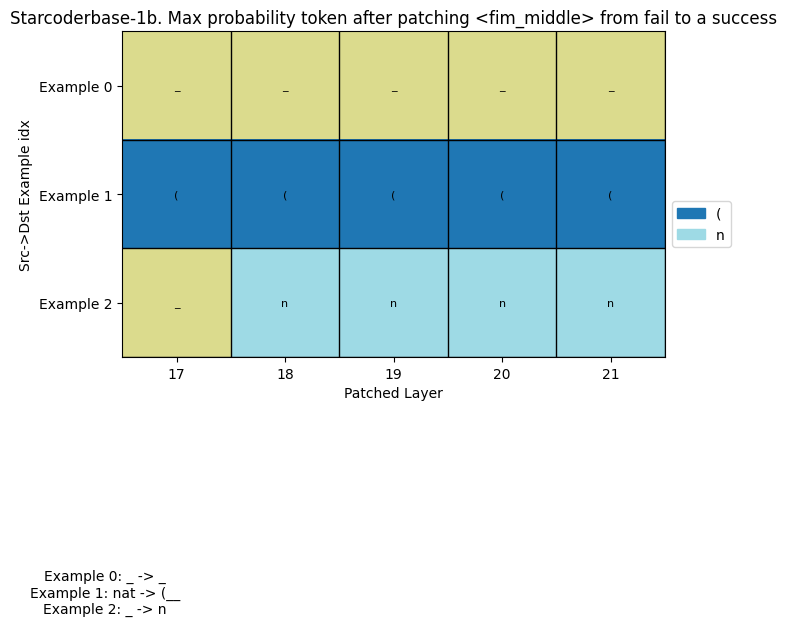

({0: {'pred': 81},
  1: {'pred': 26},
  2: {'pred': 81},
  3: {'pred': 81},
  4: {'pred': 26},
  5: {'pred': 96},
  6: {'pred': 81},
  7: {'pred': 26},
  8: {'pred': 96},
  9: {'pred': 81},
  10: {'pred': 26},
  11: {'pred': 96},
  12: {'pred': 81},
  13: {'pred': 26},
  14: {'pred': 96}},
 [[81, 81, 81, 81, 81], [26, 26, 26, 26, 26], [81, 96, 96, 96, 96]])

In [215]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import numpy as np
# colours = im.cmap(im.norm(np.unique(pred_results)))
# len_colors = len(colours)

plt.figure(figsize=(7,7))

# make labels
flat_results = [x for y in pred_results for x in y]
labels = set([model.tokenizer.decode([x]) for x in flat_results])
labels = list(set(flat_results))
labels.sort()
print(labels)


# set color map
im = plt.imshow(pred_results, norm="log", cmap="tab20")

plt.yticks(range(len(pred_results)), [f"Example {i}" for i in idx_range])
plt.xticks(range(len(layers)), layers)
plt.xlabel("Patched Layer")
plt.ylabel("Src->Dst Example idx")
plt.title(f"Starcoderbase-1b. Max probability token after patching <fim_middle> from fail to a success")

# make legend

# get map of labels to colors from image
color_map = im.cmap(im.norm(np.unique(pred_results)))
# use map to make legend
plt.legend(loc="upper left", bbox_to_anchor=(1,0.5), handles=[plt.Rectangle((0,0),1,1, color=color_map[i], label=model.tokenizer.decode(labels[i])) for i in range(len(labels))])


# add grid between examples and layers (halfway!)
plt.hlines([i+0.5 for i in range(len(pred_results))], *plt.xlim(), color="black", linewidth=1)
plt.vlines([i+0.5 for i in range(len(layers))], *plt.ylim(), color="black", linewidth=1)


# build an annotations dict for each square in grid with values from probs_patched_results
annotations = {i:{} for i in range(len(layers)*len(pred_results))}

for i in range(len(pred_results)):
    for j in range(len(layers)):
        probs = probs_patched_results[i][j]
        
# create tuples of positions
positions =[(x , y ) for x in range(len(layers)) for y in range(len(pred_results))]

for i in range(len(pred_results)):
    for j in range(len(layers)):
        probs = probs_patched_results[i][j]
        annotations[i+len(pred_results)*j] = {"pred": pred_results[i][j]}
        
# add annotations
for pos, text in annotations.items():
    plt.annotate(model.tokenizer.decode(text["pred"]), xy=positions[pos],color="black", fontsize=8, ha="center", va="center")


range_str = '-'.join([str(i) for i in idx_range])
# plt.savefig(f"results/starcoderbase-1b_patch-fail_to_success_idx-{range_str}_layers-{layers[0]}-{layers[-1]}.pdf", bbox_inches="tight")

legend = "\n".join([f"Example {idx_range[i]}: {model.tokenizer.decode(dirs[i][0])} -> {model.tokenizer.decode(dirs[i][1])}" for i in range(len(dirs))])

## add caption to fig
plt.figtext(0.1, - 0.1, legend, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()
annotations, pred_results